<a href="https://colab.research.google.com/github/jessieou/google-cluster/blob/main/clusterdata_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google trace analysis colab

This colab provides several example queries and graphs using [Altair](https://altair-viz.github.io/) for the 2019 Google cluster trace. Further examples will be added over time.

**Important:** in order to be able to run the queries you will need to:

1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


In [1]:
#@title Please input your project id
import pandas as pd
import numpy as np
import altair as alt
from google.cloud import bigquery
# Provide credentials to the runtime
from google.colab import auth
from google.cloud.bigquery import magics

auth.authenticate_user()
print('Authenticated')
project_id = 'cs229-cluster' #@param {type: "string"}
# Set the default project id for %bigquery magic
magics.context.project = project_id

# Use the client to run queries constructed from a more complicated function.
client = bigquery.Client(project=project_id)

Authenticated


# Basic queries

This section shows the most basic way of querying the trace using the [bigquery magic](https://googleapis.dev/python/bigquery/latest/magics.html)

In [12]:
%%bigquery
SELECT machine_id,
    average_usage.cpus as cpu_usage,
    average_usage.memory AS memory_usage
FROM `google.com:google-cluster-data`.clusterdata_2019_a.instance_usage
# GROUP BY machine_id
# ORDER BY num DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,machine_id,cpu_usage,memory_usage
0,39175913234,0.004532,0.002998
1,1715246892,0.000225,0.000587
2,21263130,0.000201,0.000607
3,1715246892,0.000295,0.000493
4,92117608309,0.000241,0.000683
5,1574304477,0.000102,0.000299
6,6739828469,0.000237,0.000315
7,21285498,0.000083,0.000232
8,75505055405,0.000106,0.000306
9,62185092,0.000112,0.000296


In [19]:
# %%bigquery
# SELECT
#   start_time AS time,
#     collection_id,
#     instance_index,
#     machine_id,
#     average_usage.cpus AS cpu_usage,
#     average_usage.memory AS memory_usage
#   FROM `google.com:google-cluster-data`.clusterdata_2019_a.instance_usage
#   WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
#     AND (end_time - start_time) >= (5 * 60 * 1e6)
#   limit 100000



def query_machine_usage(cell):
  return '''
SELECT
  start_time AS time,
    collection_id,
    instance_index,
    machine_id,
    average_usage.cpus AS cpu_usage,
    average_usage.memory AS memory_usage
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
  limit 100000
  '''.format(cell=cell)

cell = 'a' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

ts_usage = client.query(query_machine_usage(cell)).to_dataframe()


In [20]:
ts_usage

,time,collection_id,instance_index,machine_id,cpu_usage,memory_usage
0,1729800000000,151900615892,23,72033577849,0.000065,0.000133
1,1137900000000,39516997747,2555,2960767116,0.000424,0.000123
2,1137300000000,39516997747,3519,1574793943,0.000286,0.000118
3,2353500000000,39516997747,2822,1376368800,0.000094,0.000094
4,2356200000000,39516997747,5402,1377596911,0.000632,0.000120
...,...,...,...,...,...,...
99995,1242000000000,359282970550,5,2059348358,0.000386,0.000680
99996,365400000000,359282970550,2,1579815409,0.000520,0.000673
99997,1003500000000,359282970550,2,1579815409,0.000484,0.000682
99998,311700000000,359282970550,6,21365709,0.000420,0.000647


In [22]:
# the CPU usage appears to be normalized - likely stored CPU usage in 1/1000th of a CPU --> multiply by 1000 to convert to “core equivalents”
ts_usage['cpu_usage'] = ts_usage['cpu_usage'] * 1000

print(ts_usage['cpu_usage'].describe())

count    100000.000000
mean          6.610308
std          14.696047
min           0.000000
25%           0.271797
50%           1.165390
75%           6.797791
max         642.578125
Name: cpu_usage, dtype: float64


In [23]:
machine_ts_check = (
    ts_usage.groupby(['machine_id'])
      .agg(total_cpu_usage=('cpu_usage', 'sum'),
           mean_cpu_usage=('cpu_usage', 'mean'),
           num_records=('cpu_usage', 'count'))
      .reset_index()
)

print(machine_ts_check.head())
print(machine_ts_check.describe())

   machine_id  total_cpu_usage  mean_cpu_usage  num_records
0          -1        11.525154        2.881289            4
1    20731766        32.149315        4.018664            8
2    20732703        59.630394        4.969199           12
3    20732904        18.362045        2.295256            8
4    20732905        12.843132        1.834733            7
                machine_id  total_cpu_usage  mean_cpu_usage  num_records
count               9961.0      9961.000000     9961.000000  9961.000000
mean    69841262639.999695        66.361895        6.583305    10.039153
std    106902816599.175323        58.936309        5.833192     4.249010
min                   -1.0         0.106812        0.106812     1.000000
25%           1377672043.0        23.341179        2.787272     7.000000
50%          23749195359.0        47.700882        4.914284    10.000000
75%          92036223205.0        93.736649        8.793904    13.000000
max         400224536580.0       668.228149      132.812

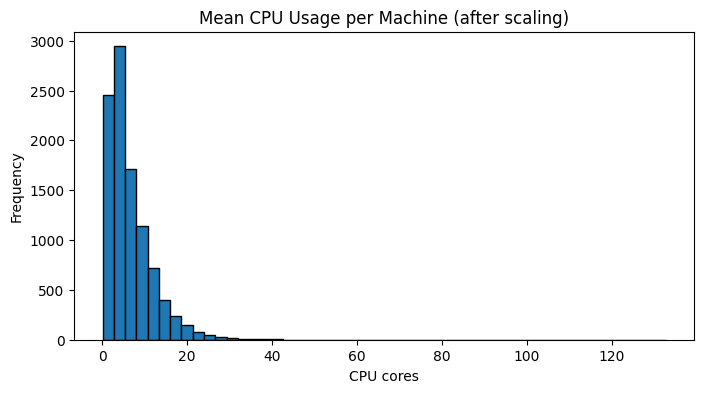

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(machine_ts_check['mean_cpu_usage'], bins=50, edgecolor='k')
plt.title("Mean CPU Usage per Machine (after scaling)")
plt.xlabel("CPU cores")
plt.ylabel("Frequency")
plt.show()

### Process data into time series lag  

In [26]:
df = ts_usage

In [27]:
keep = ['machine_id','time','cpu_usage','memory_usage']
df = df[[c for c in keep if c in df.columns]]
df.head(10)

,machine_id,time,cpu_usage,memory_usage
0,72033577849,1729800000000,0.064850,0.000133
1,2960767116,1137900000000,0.424385,0.000123
2,1574793943,1137300000000,0.286102,0.000118
3,1376368800,2353500000000,0.094414,0.000094
4,1377596911,2356200000000,0.632286,0.000120
5,86174011132,2248200000000,0.782013,0.000135
6,188899348311,694500000000,0.442505,0.000120
7,92109380791,690300000000,0.176430,0.000097
8,86168946013,693000000000,0.438690,0.000127
9,151931037,2482200000000,0.089645,0.000130


In [28]:
# --- Clean time: treat as relative offsets and bin by integer windows (no datetimes) ---
# Make numeric, drop missing
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df = df.dropna(subset=['time','cpu_usage','machine_id'])

# Normalize to start at 0 to avoid giant integers
t0 = df['time'].min()
df['time_off'] = (df['time'] - t0).astype('int64')

# Define window = 5 minutes in microseconds
FIVE_MIN_US = 5 * 60 * 1_000_000  # 5 min * 60 sec * 1e6 µs

# Integer bin index for each row
df['win'] = (df['time_off'] // FIVE_MIN_US).astype('int64')

df

/tmp/ipython-input-3438963611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_numeric(df['time'], errors='coerce')


,machine_id,time,cpu_usage,memory_usage,time_off,win
0,72033577849,1729800000000,0.064850,0.000133,1729500000000,5765
1,2960767116,1137900000000,0.424385,0.000123,1137600000000,3792
2,1574793943,1137300000000,0.286102,0.000118,1137000000000,3790
3,1376368800,2353500000000,0.094414,0.000094,2353200000000,7844
4,1377596911,2356200000000,0.632286,0.000120,2355900000000,7853
...,...,...,...,...,...,...
99995,2059348358,1242000000000,0.386238,0.000680,1241700000000,4139
99996,1579815409,365400000000,0.519753,0.000673,365100000000,1217
99997,1579815409,1003500000000,0.484467,0.000682,1003200000000,3344
99998,21365709,311700000000,0.419617,0.000647,311400000000,1038


In [29]:
# --- Aggregate to machine x window ---
agg = {
    'cpu_usage': 'sum',                 # total CPU per machine-window
    'mem_usage': 'sum',                 # total memory per machine-window
}
machine_ts = (df
              .groupby(['machine_id','win'], as_index=False)
              .agg({k:v for k,v in agg.items() if k in df.columns})
              .sort_values(['machine_id','win'])
             )

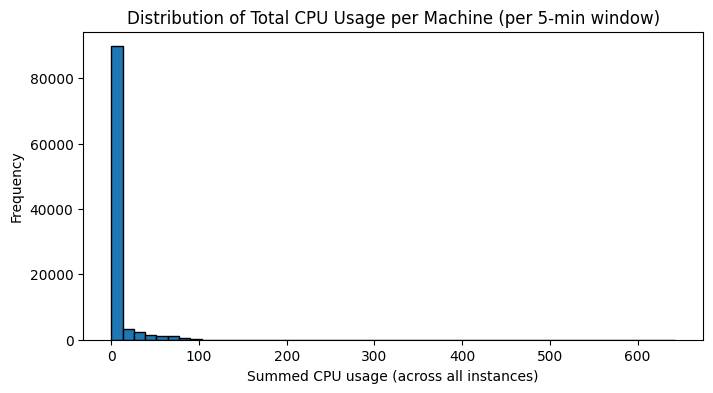

In [30]:

plt.figure(figsize=(8,4))
plt.hist(machine_ts['cpu_usage'], bins=50, edgecolor='k')
plt.title("Distribution of Total CPU Usage per Machine (per 5-min window)")
plt.xlabel("Summed CPU usage (across all instances)")
plt.ylabel("Frequency")
plt.show()


In [31]:
# --- Create lag features per machine (past 15 min) ---
def add_lags(g, target='cpu_usage', lags=(1,2,3)):
    g = g.sort_values('win').copy()
    for L in lags:
        g[f'{target}_lag{L}'] = g[target].shift(L)
    return g

machine_ts = (machine_ts
              .groupby('machine_id', group_keys=False)
              .apply(add_lags, target='cpu_usage', lags=(1,2,3))
             )


/tmp/ipython-input-535543382.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_lags, target='cpu_usage', lags=(1,2,3))


In [32]:
machine_ts

,machine_id,win,cpu_usage,cpu_usage_lag1,cpu_usage_lag2,cpu_usage_lag3
0,-1,2853,0.473022,NaN,NaN,NaN
1,-1,3460,2.693176,0.473022,NaN,NaN
2,-1,6231,0.348091,2.693176,0.473022,NaN
3,-1,7560,8.010864,0.348091,2.693176,0.473022
4,20731766,156,6.439209,NaN,NaN,NaN
...,...,...,...,...,...,...
99936,399831297385,8720,1.554489,NaN,NaN,NaN
99937,399834569233,8830,0.277519,NaN,NaN,NaN
99938,400002655462,8861,132.812500,NaN,NaN,NaN
99939,400020037714,8763,8.361816,NaN,NaN,NaN


In [33]:
# Drop rows without full history
lag_cols = [c for c in machine_ts.columns if c.startswith('cpu_usage_lag')]
machine_ts = machine_ts.dropna(subset=lag_cols)

# --- Chronological Train/test split (first 80% train, last 20% test) ---
features = lag_cols
X = machine_ts[features]
y = machine_ts['cpu_usage']

split = int(0.8 * len(machine_ts))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [34]:
print(X_train.shape)
print(X_test.shape)
X_train.head()

(56239, 3)
(14060, 3)


,cpu_usage_lag1,cpu_usage_lag2,cpu_usage_lag3
3,0.348091,2.693176,0.473022
7,6.301880,7.316589,6.439209
8,0.341415,6.301880,7.316589
9,0.204086,0.341415,6.301880
10,0.273705,0.204086,0.341415


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# --- Baseline model ---
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"Baseline Linear Regression RMSE: {rmse:.6f}")

# human-readable timestamp for plotting later -> window start (in microseconds since trace start) for each row
machine_ts['window_start_us'] = t0 + machine_ts['win'] * FIVE_MIN_US
# datetime-like labels for charts, scale down before to_timedelta
machine_ts['ts_plot'] = pd.Timestamp('2019-01-01') + pd.to_timedelta(machine_ts['window_start_us'] / 1e6, unit='s')

Baseline Linear Regression RMSE: 277.231527


/tmp/ipython-input-3331020840.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_ts['window_start_us'] = t0 + machine_ts['win'] * FIVE_MIN_US
/tmp/ipython-input-3331020840.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_ts['ts_plot'] = pd.Timestamp('2019-01-01') + pd.to_timedelta(machine_ts['window_start_us'] / 1e6, unit='s')


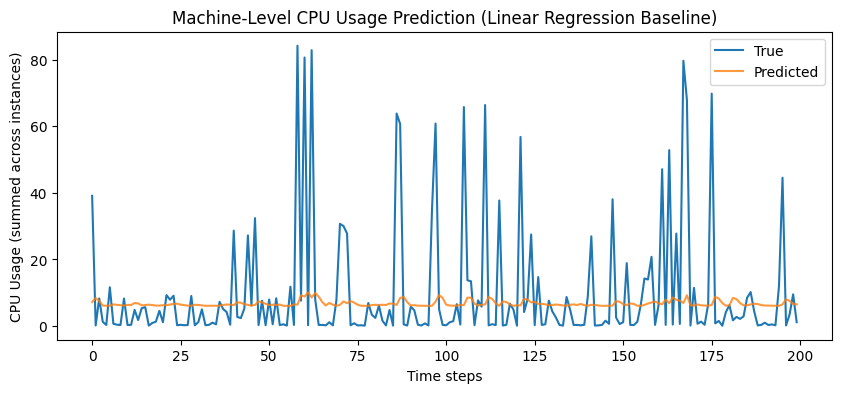

In [38]:


plt.figure(figsize=(10,4))
plt.plot(y_test.values[:200], label='True')
plt.plot(y_pred[:200], label='Predicted', alpha=0.8)
plt.title("Machine-Level CPU Usage Prediction (Linear Regression Baseline)")
plt.xlabel("Time steps")
plt.ylabel("CPU Usage (summed across instances)")
plt.legend()
plt.show()

In [39]:
print("Mean of y_test:", y_test.mean())
print("Mean of predictions:", y_pred.mean())
print("Std of y_test:", y_test.std())
print("Std of predictions:", y_pred.std())

Mean of y_test: 7.950560568406606
Mean of predictions: 6.646083724845247
Std of y_test: 16.610620283307643
Std of predictions: 0.810189041220932


Top machines by sample count: [np.int64(159596203493), np.int64(92003311000), np.int64(80223523049), np.int64(345111144299), np.int64(375996896338), np.int64(66703270262)]


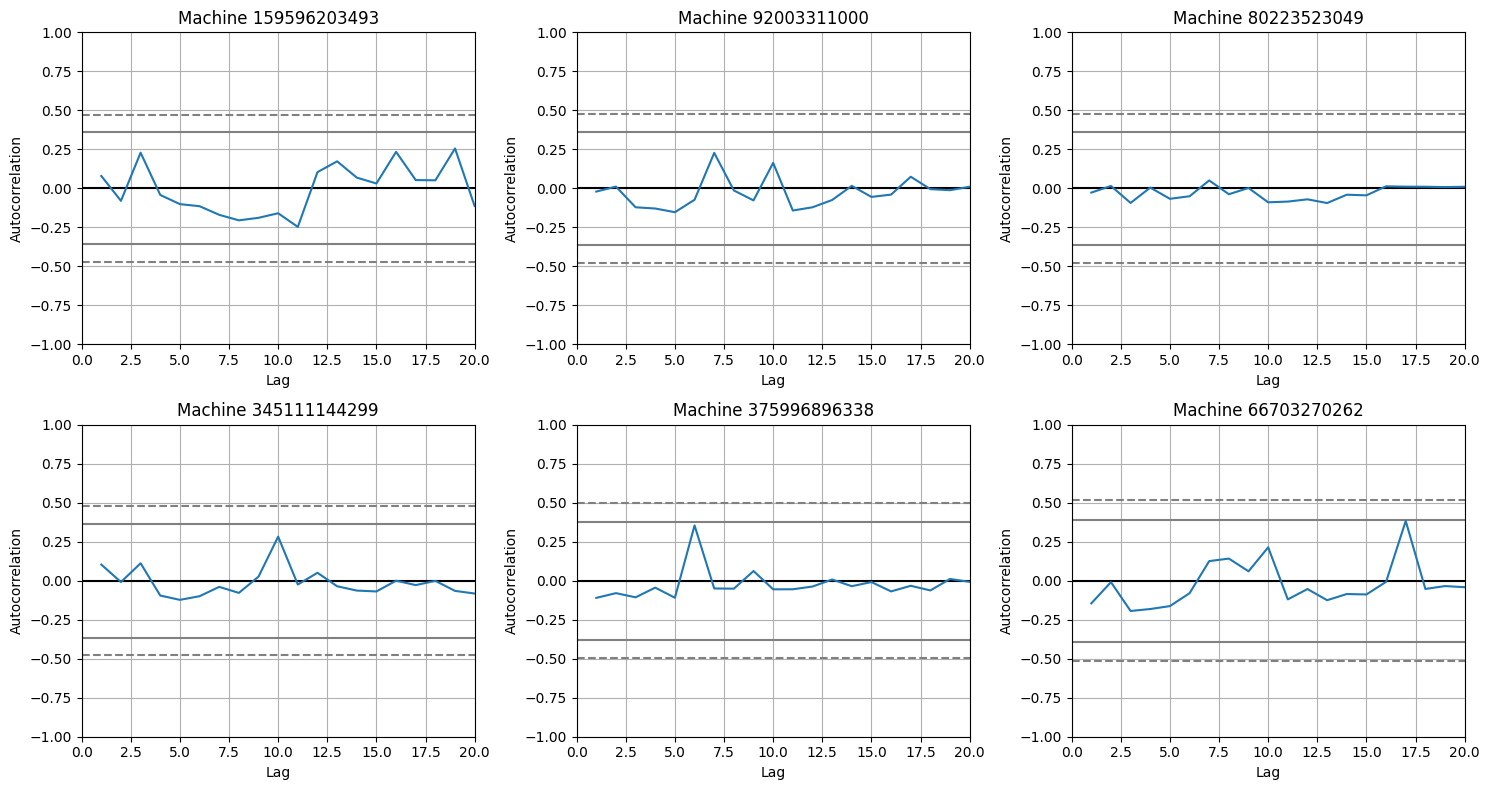

In [42]:
# Pick top N machines with the most records
top_machines = (
    machine_ts['machine_id']
    .value_counts()
    .head(6)        # limit to top 6
    .index
)
print("Top machines by sample count:", list(top_machines))

from pandas.plotting import autocorrelation_plot
n = len(top_machines)
ncols = 3
nrows = int(np.ceil(n / ncols))

plt.figure(figsize=(15, 8))
for i, mid in enumerate(top_machines, 1):
    plt.subplot(nrows, ncols, i)
    series = (
        machine_ts[machine_ts['machine_id'] == mid]
        .sort_values('win')['cpu_usage']
    )
    autocorrelation_plot(series)
    plt.title(f'Machine {mid}')
    plt.xlim(0, 20)   # limit to first 20 lags
plt.tight_layout()
plt.show()

In [40]:
machine_autocorr = (
    machine_ts.groupby('machine_id')['cpu_usage']
    .apply(lambda s: s.sort_values().autocorr(lag=1))
    .dropna()
    .sort_values(ascending=False)
)

print(machine_autocorr.head(10))


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


machine_id
384609442291    1.0
383890497590    1.0
1377075774      1.0
383934576827    1.0
20734325        1.0
248232520864    1.0
380390930251    1.0
380710558819    1.0
23744702652     1.0
23744673029     1.0
Name: cpu_usage, dtype: float64


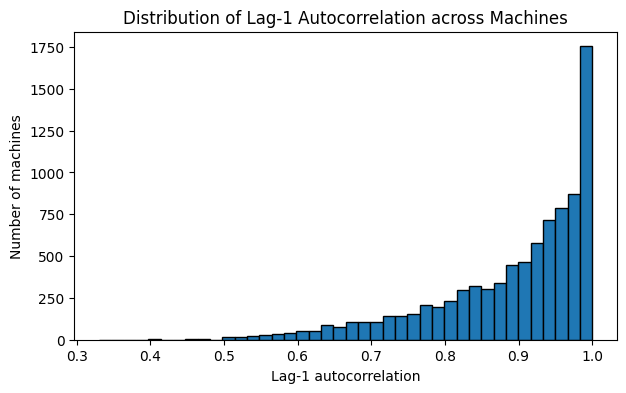

In [41]:
plt.figure(figsize=(7,4))
plt.hist(machine_autocorr, bins=40, edgecolor='k')
plt.title("Distribution of Lag-1 Autocorrelation across Machines")
plt.xlabel("Lag-1 autocorrelation")
plt.ylabel("Number of machines")
plt.show()


In [2]:
%%bigquery
SELECT capacity.cpus AS cpu_cap,
capacity.memory AS memory_cap,
COUNT(DISTINCT machine_id) AS num_machines
FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events
GROUP BY 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,cpu_cap,memory_cap,num_machines
0,NaN,NaN,459
1,1.000000,0.500000,1672
2,1.000000,1.000000,643
3,1.000000,0.250000,52
4,0.479492,0.250000,1
5,0.708984,0.333496,1417
6,0.708984,0.666992,480
7,0.708984,0.250000,1
8,0.958984,0.500000,179
9,0.958984,1.000000,73


In [ ]:
%%bigquery
SELECT COUNT(DISTINCT collection_id) AS collections FROM
`google.com:google-cluster-data`.clusterdata_2019_a.collection_events;

# Cell level resource usage time series

This query takes a cell as input and plots a resource usage time-series for every hour of the trace broken down by tier.

In [11]:
#@title Select a cell and a resource to plot the cell level usage series

def query_cell_capacity(cell):
  return '''
SELECT SUM(cpu_cap) AS cpu_capacity,
  SUM(memory_cap) AS memory_capacity
FROM (
  SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
    MAX(capacity.memory) AS memory_cap
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
  GROUP BY 1
)
  '''.format(cell=cell)

def query_per_instance_usage_priority(cell):
  return '''
SELECT u.time AS time,
  u.collection_id AS collection_id,
  u.instance_index AS instance_index,
  e.priority AS priority,
  CASE
    WHEN e.priority BETWEEN 0 AND 99 THEN '1_free'
    WHEN e.priority BETWEEN 100 AND 115 THEN '2_beb'
    WHEN e.priority BETWEEN 116 AND 119 THEN '3_mid'
    ELSE '4_prod'
  END AS tier,
  u.cpu_usage AS cpu_usage,
  u.memory_usage AS memory_usage
FROM (
  SELECT start_time AS time,
    collection_id,
    instance_index,
    machine_id,
    average_usage.cpus AS cpu_usage,
    average_usage.memory AS memory_usage
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
) AS u JOIN (
  SELECT collection_id, instance_index, machine_id,
    MAX(priority) AS priority
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_events
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  GROUP BY 1, 2, 3
) AS e ON u.collection_id = e.collection_id
  AND u.instance_index = e.instance_index
  AND u.machine_id = e.machine_id
  '''.format(cell=cell)

def query_per_tier_utilization_time_series(cell, cpu_capacity, memory_capacity):
  return '''
SELECT CAST(FLOOR(time/(1e6 * 60 * 60)) AS INT64) AS hour_index,
  tier,
  SUM(cpu_usage) / (12 * {cpu_capacity}) AS avg_cpu_usage,
  SUM(memory_usage) / (12 * {memory_capacity}) AS avg_memory_usage
FROM ({table})
GROUP BY 1, 2 ORDER BY hour_index
  '''.format(table=query_per_instance_usage_priority(cell),
             cpu_capacity=cpu_capacity, memory_capacity=memory_capacity)

def run_query_utilization_per_time_time_series(cell):
  cell_cap = client.query(query_cell_capacity(cell)).to_dataframe()
  query = query_per_tier_utilization_time_series(
      cell,
      cell_cap['cpu_capacity'][0],
      cell_cap['memory_capacity'][0])
  time_series = client.query(query).to_dataframe()
  return time_series

cell = 'c' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
hourly_usage = run_query_utilization_per_time_time_series(cell)

# CPU graph
cpu = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_cpu_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_cpu_usage']
  )
cpu.encoding.x.title = "Hour"
cpu.encoding.y.title = "Average CPU usage"
cpu.display()

# Memory graph
memory = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_memory_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_memory_usage']
  )
memory.encoding.x.title = "Hour"
memory.encoding.y.title = "Average memory usage"
memory.display()

alt.Chart(...)

alt.Chart(...)

#Per machine resource usage distribution

This query takes a cell as input and plots a per-machine resource utilization CDF.

In [ ]:
#@title Select a cell and plot its per-machine resource utilization CDFs

# Functions to plot CDFs using Altair
def pick_quantiles_from_tall_dataframe(data, qcol, name=""):
  quantiles = pd.DataFrame([x for x in data[qcol]]).transpose()
  if name != "":
    quantiles.columns = data[name]
  return quantiles

# - data: a dataframe with one row and one or more columns of quantiles (results
#   returned from APPROX_QUANTILES)
# - qcols: a list of names of the quantiles
# - names: the names of each returned quantiles' columns.
def pick_quantiles_from_wide_dataframe(data, qcols, names=[]):
  quantiles = {}
  i = 0
  for qcol in qcols:
    col_name = qcol
    if i < len(names):
      col_name = names[i]
    quantiles[col_name] = data[qcol][0]
    i+=1
  return pd.DataFrame(quantiles)

# - quantiles: a dataframe where each column contains the quantiles of one
#   data set. The index (i.e. row names) of the dataframe is the quantile. The
#   column names are the names of the data set.
def plot_cdfs(quantiles, xlab="Value", ylab="CDF",
              legend_title="dataset", labels=[],
              interactive=False,
              title=''):
  dfs = []
  label = legend_title
  yval = range(quantiles.shape[0])
  esp = 1.0/(len(quantiles)-1)
  yval = [y * esp for y in yval]
  while label == xlab or label == ylab:
    label += '_'
  for col_idx, col in enumerate(quantiles.columns):
    col_label = col
    if col_idx < len(labels):
      col_label = labels[col_idx]
    dfs.append(pd.DataFrame({
        label: col_label,
        xlab: quantiles[col],
        ylab: yval
    }))
  cdfs = pd.concat(dfs)
  lines = alt.Chart(cdfs).mark_line().encode(
    # If you can draw a CDF, it has to be continuous real-valued
    x=xlab+":Q",
    y=ylab+":Q",
    color=label+":N"
  ).properties(
    title=title
  )
  if not interactive:
    return lines
  # Create a selection that chooses the nearest point & selects based on x-value
  nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=[ylab], empty='none')
  # Transparent selectors across the chart. This is what tells us
  # the y-value of the cursor
  selectors = alt.Chart(cdfs).mark_point().encode(
    y=ylab+":Q",
    opacity=alt.value(0),
  ).properties(
    selection=nearest
  )

  # Draw text labels near the points, and highlight based on selection
  text = lines.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest,
                       alt.Text(xlab+":Q", format=".2f"),
                       alt.value(' '))
  )

  # Draw a rule at the location of the selection
  rules = alt.Chart(cdfs).mark_rule(color='gray').encode(
    y=ylab+":Q",
  ).transform_filter(
    nearest.ref()
  )
  # Draw points on the line, and highlight based on selection
  points = lines.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
  )
  # Put the five layers into a chart and bind the data
  return alt.layer(lines, selectors, rules, text, points).interactive(
      bind_y=False)

# Functions to create the query

def query_machine_capacity(cell):
  return '''
SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
  MAX(capacity.memory) AS memory_cap
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
GROUP BY 1
  '''.format(cell=cell)

def query_top_level_instance_usage(cell):
  return '''
SELECT CAST(FLOOR(start_time/(1e6 * 300)) * (1000000 * 300) AS INT64) AS time,
  collection_id,
  instance_index,
  machine_id,
  average_usage.cpus AS cpu_usage,
  average_usage.memory AS memory_usage
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  AND (end_time - start_time) >= (5 * 60 * 1e6)
  '''.format(cell=cell)

def query_machine_usage(cell):
  return '''
SELECT u.time AS time,
  u.machine_id AS machine_id,
  SUM(u.cpu_usage) AS cpu_usage,
  SUM(u.memory_usage) AS memory_usage,
  MAX(m.cpu_cap) AS cpu_capacity,
  MAX(m.memory_cap) AS memory_capacity
FROM ({instance_usage}) AS u JOIN
 ({machine_capacity}) AS m
ON u.machine_id = m.machine_id
GROUP BY 1, 2
  '''.format(instance_usage = query_top_level_instance_usage(cell),
             machine_capacity = query_machine_capacity(cell))

def query_machine_utilization_distribution(cell):
  return '''
SELECT APPROX_QUANTILES(IF(cpu_usage > cpu_capacity, 1.0, cpu_usage / cpu_capacity), 100) AS cpu_util_dist,
  APPROX_QUANTILES(IF(memory_usage > memory_capacity, 1.0, memory_usage / memory_capacity), 100) AS memory_util_dist
FROM ({table})
  '''.format(table = query_machine_usage(cell))

cell = 'd' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
query = query_machine_utilization_distribution(cell)
machine_util_dist = client.query(query).to_dataframe()
plot_cdfs(pick_quantiles_from_wide_dataframe(machine_util_dist, ['cpu_util_dist', 'memory_util_dist'], ['CPU', 'Memory']), xlab='x - resource utilization (%)', ylab="Probability (resource utilization < x)", interactive=True)